In [1]:
import tensorflow as tf
print (tf.__version__)

2.4.1


In [2]:
tf.keras.backend.clear_session()

In [1]:
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, Flatten, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from tensorflow.keras.layers import ZeroPadding2D
from pandas_profiling import ProfileReport

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import cv2
import tensorflow_hub as hub

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
project_path = '/content/drive/My Drive/DogBreed_Classification/'

In [6]:
from zipfile import ZipFile
with ZipFile(project_path+'train.zip','r') as z:
  z.extractall()

In [7]:
from zipfile import ZipFile
with ZipFile(project_path+'test.zip','r') as z:
  z.extractall()

In [8]:
submission = pd.read_csv(project_path+'sample_submission.csv.zip')
test_img = submission['id']
submission.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,bedlington_terrier,bernese_mountain_dog,black-and-tan_coonhound,blenheim_spaniel,bloodhound,bluetick,border_collie,border_terrier,borzoi,boston_bull,bouvier_des_flandres,boxer,brabancon_griffon,briard,brittany_spaniel,bull_mastiff,cairn,cardigan,chesapeake_bay_retriever,chihuahua,chow,clumber,cocker_spaniel,collie,curly-coated_retriever,dandie_dinmont,dhole,dingo,doberman,...,norwegian_elkhound,norwich_terrier,old_english_sheepdog,otterhound,papillon,pekinese,pembroke,pomeranian,pug,redbone,rhodesian_ridgeback,rottweiler,saint_bernard,saluki,samoyed,schipperke,scotch_terrier,scottish_deerhound,sealyham_terrier,shetland_sheepdog,shih-tzu,siberian_husky,silky_terrier,soft-coated_wheaten_terrier,staffordshire_bullterrier,standard_poodle,standard_schnauzer,sussex_spaniel,tibetan_mastiff,tibetan_terrier,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
1,00102ee9d8eb90812350685311fe5890,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
2,0012a730dfa437f5f3613fb75efcd4ce,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
3,001510bc8570bbeee98c8d80c8a95ec1,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333

In [3]:
labels = pd.read_csv(project_path+'labels.csv.zip')
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [ ]:
#!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

In [5]:
profile = ProfileReport(labels,title='Dog Breeds Profiling', explorative=True)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/15 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
profile.to_file("Dog Breeds Profile Report.html")

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [10]:
breed_count=labels['breed'].value_counts()
breed_count.head()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
Name: breed, dtype: int64

In [11]:
model_checkpoint=tf.keras.callbacks.ModelCheckpoint('dogbreed_cnn.h5', #where to save the model
                                                    save_best_only=True, 
                                                    monitor='val_accuracy', 
                                                    mode='max',
                                                    min_delta=0.001,
                                                    patience=5,
                                                    verbose=1)
model_es=tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',min_delta=0.001,patience=5,mode='max',verbose=1)
model_lr=tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.01,patience=5,verbose=1,mode='auto',min_delta=0.0001)

In [ ]:
targets = pd.Series(labels['breed'])
one_hot = pd.get_dummies(targets)
one_hot_labels = np.asarray(one_hot)

encoder = LabelEncoder()
label = encoder.fit_transform(labels['breed'])
y_label=tf.keras.utils.to_categorical(label, num_classes=None, dtype='int')#, 120)

In [ ]:
IMG_SIZE=128
channels=1
EPOCHS=100
BATCH=32

In [ ]:
x_features=[]
y_feature=[]
#label=[]

i=0
for f, img in tqdm(labels.values): #f for image id, img for dog breed
  #Using cv2.imread results in BGR images, instead of the standard RGB as below
  train_img = cv2.imread('./train/{}.jpg'.format(f),0) #0 for grayscale & 1 for color (o/p is bgr)
  train_img_resize = cv2.resize(train_img, (IMG_SIZE,IMG_SIZE))
  label = one_hot_labels[i]
  x_features.append(train_img_resize)
  y_feature.append(label)
  i+=1
  #label.append(img)

100%|██████████| 10222/10222 [00:15<00:00, 669.49it/s]


In [ ]:
x_test_feature=[]
i=0
for f in tqdm(test_img.values):
    img = cv2.imread('./test/{}.jpg'.format(f),0)
    img_resize = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    x_test_feature.append(img_resize)

100%|██████████| 10357/10357 [00:15<00:00, 689.32it/s]


In [ ]:
x_train_data = np.array(x_features,np.float32) / 255.0  #Division by 255. for normalisation
print(x_train_data.shape)
x_train_data = np.expand_dims(x_train_data, axis=3)
print(x_train_data.shape)

#y_label = np.array(y_label)
#print(y_label.shape)
y_train_data = np.array(y_feature)
print(y_train_data)

(10222, 128, 128)
(10222, 128, 128, 1)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [ ]:
x_test_data = np.array(x_test_feature,np.float32) / 255.0  #Division by 255. for normalisation
print(x_test_data.shape)
x_test_data = np.expand_dims(x_test_data, axis=3)
print(x_test_data.shape)

(10357, 128, 128)
(10357, 128, 128, 1)


In [ ]:
x_train,x_val,y_train,y_val=train_test_split(x_train_data,y_train_data,test_size=0.2,random_state=42)
print(x_train.shape)
print(x_val.shape)

(8177, 128, 128, 1)
(2045, 128, 128, 1)


In [ ]:
model1 = Sequential()
model1.add(Conv2D(32,(5,5),activation='relu',input_shape=(IMG_SIZE,IMG_SIZE,channels)))
model1.add(MaxPooling2D(pool_size=3))
#model1.add(Dropout(0.2))
model1.add(Conv2D(filters=64, kernel_size=4, padding='same',activation='relu'))
model1.add(MaxPooling2D(pool_size=2))
#model1.add(Dropout(0.2))
model1.add(Conv2D(128, kernel_size=3, padding='same',activation='relu'))
model1.add(MaxPooling2D(pool_size=2))
#model1.add(Dropout(0.8))
model1.add(Conv2D(128, kernel_size=2, padding='same',activation='relu'))
model1.add(MaxPooling2D(pool_size=2))
#model1.add(Dropout(0.8))
model1.add(Flatten())
#fully connected layer
model1.add(Dense(units=500,activation='relu'))
model1.add(Dropout(0.2))
#output layer
model1.add(Dense(units=120,activation='softmax'))

In [ ]:
optimizer=Adam(lr=0.01)
model1.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])
model1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 124, 124, 32)      832       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 41, 41, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 41, 41, 64)        32832     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 20, 20, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 20, 20, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 10, 10, 128)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 10, 10, 128)      

In [ ]:
history = model1.fit(x_train, y_train,
                     batch_size=BATCH,
                     epochs=20,
                     validation_data=(x_val,y_val),
                     callbacks = [model_checkpoint,model_lr],
                     verbose=1)

Epoch 1/20
82/82 [==============================] - 8s 89ms/step - loss: 6.3130 - accuracy: 0.0076 - val_loss: 4.7839 - val_accuracy: 0.0098

Epoch 00001: val_accuracy improved from -inf to 0.00978, saving model to dogbreed_cnn.h5
Epoch 2/20
82/82 [==============================] - 7s 83ms/step - loss: 4.7813 - accuracy: 0.0114 - val_loss: 4.7845 - val_accuracy: 0.0098

Epoch 00002: val_accuracy did not improve from 0.00978
Epoch 3/20
82/82 [==============================] - 7s 83ms/step - loss: 4.7773 - accuracy: 0.0119 - val_loss: 4.7855 - val_accuracy: 0.0098

Epoch 00003: val_accuracy did not improve from 0.00978
Epoch 4/20
82/82 [==============================] - 7s 83ms/step - loss: 4.7788 - accuracy: 0.0137 - val_loss: 4.7860 - val_accuracy: 0.0098

Epoch 00004: val_accuracy did not improve from 0.00978
Epoch 5/20
82/82 [==============================] - 7s 82ms/step - loss: 4.7759 - accuracy: 0.0113 - val_loss: 4.7857 - val_accuracy: 0.0098

Epoch 00005: val_accuracy did not im

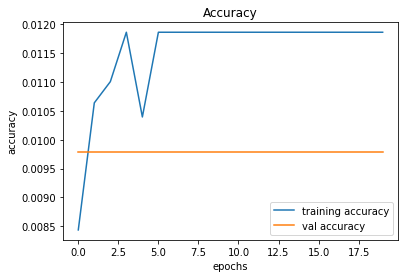

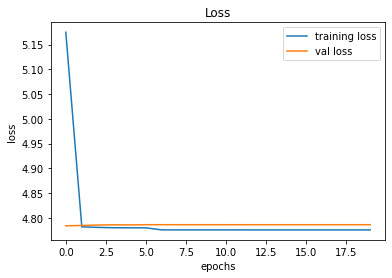

In [ ]:
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [ ]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.2,
                                                                height_shift_range=0.2,
                                                                rescale=1./255,
                                                                rotation_range=30,
                                                                shear_range=0.2,
                                                                zoom_range=0.2,
                                                                horizontal_flip=True,
                                                                #vertical_flip=True,
                                                                fill_mode='nearest')
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [ ]:
training_data = train_datagen.flow(x_train,y=y_train,batch_size=BATCH)
testing_data = test_datagen.flow(x_val,y=y_val,batch_size=BATCH)

In [ ]:
model2 = Sequential()
#model2.add(ZeroPadding2D((1,1),input_shape=(IMG_SIZE,IMG_SIZE,channels)))
model2.add(Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=(IMG_SIZE,IMG_SIZE,channels)))
#model2.add(ZeroPadding2D((1,1)))

model2.add(Conv2D(32,kernel_size=(3,3),activation='relu'))
model2.add(Conv2D(32,kernel_size=(3,3),activation='relu'))
model2.add(MaxPooling2D(pool_size=(2,2)))

model2.add(Conv2D(64,kernel_size=(3,3),activation='relu'))
model2.add(Conv2D(64,kernel_size=(3,3),activation='relu'))
model2.add(MaxPooling2D(pool_size=(2,2)))

model2.add(Conv2D(128,kernel_size=(3,3),activation='relu'))
model2.add(Conv2D(128,kernel_size=(3,3),activation='relu'))
model2.add(MaxPooling2D(pool_size=(2,2)))

model2.add(Flatten())
model2.add(Dense(units=500,activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(units=120,activation='softmax'))

model2.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model2.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_4 (ZeroPaddin (None, 130, 130, 1)       0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 128, 128, 32)      320       
_________________________________________________________________
zero_padding2d_5 (ZeroPaddin (None, 130, 130, 32)      0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 128, 128, 32)      9248      
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 126, 126, 32)      9248      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 61, 61, 64)       

In [ ]:
history = model2.fit(training_data,
                     epochs=20,
                     steps_per_epoch= 8177//BATCH,  #Number of training images//batch_size
                     validation_data=testing_data,
                     validation_steps = 2045//BATCH, #Number of test images//batch_size
                     callbacks = [model_checkpoint,model_lr],
                     verbose=1)

Epoch 1/20
81/81 [==============================] - 26s 314ms/step - loss: 4.7872 - accuracy: 0.0095 - val_loss: 4.7831 - val_accuracy: 0.0095

Epoch 00001: val_accuracy did not improve from 0.01100
Epoch 2/20
81/81 [==============================] - 25s 306ms/step - loss: 4.7816 - accuracy: 0.0116 - val_loss: 4.7838 - val_accuracy: 0.0100

Epoch 00002: val_accuracy did not improve from 0.01100
Epoch 3/20
81/81 [==============================] - 25s 305ms/step - loss: 4.7793 - accuracy: 0.0104 - val_loss: 4.7825 - val_accuracy: 0.0110

Epoch 00003: val_accuracy did not improve from 0.01100
Epoch 4/20
81/81 [==============================] - 25s 304ms/step - loss: 4.7782 - accuracy: 0.0112 - val_loss: 4.7833 - val_accuracy: 0.0090

Epoch 00004: val_accuracy did not improve from 0.01100
Epoch 5/20
81/81 [==============================] - 25s 303ms/step - loss: 4.7768 - accuracy: 0.0098 - val_loss: 4.7831 - val_accuracy: 0.0100

Epoch 00005: val_accuracy did not improve from 0.01100
Epoch

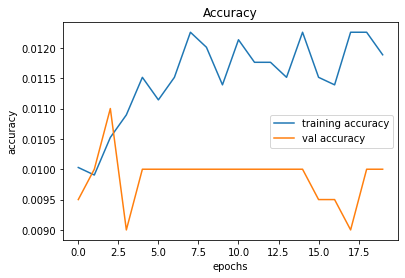

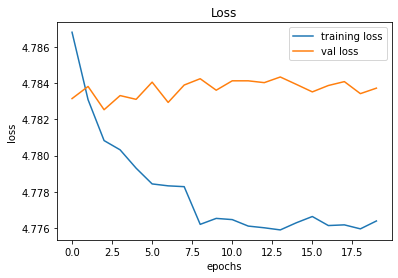

In [ ]:
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [ ]:
IMG_SIZE=128
channels=3
EPOCHS=100
BATCH=32

In [ ]:
x_features=[]
label=[]

for f, img in tqdm(labels.values): #f for image id, img for dog breed
  #Using cv2.imread results in BGR images, instead of the standard RGB as below
  train_img = cv2.imread('./train/{}.jpg'.format(f),1) #0 for grayscale & 1 for color (o/p is bgr)
  train_img_resize = cv2.resize(train_img, (IMG_SIZE,IMG_SIZE))
  x_features.append(train_img_resize)
  label.append(img)

100%|██████████| 10222/10222 [00:26<00:00, 381.67it/s]


In [ ]:
encoder = LabelEncoder()
label = encoder.fit_transform(label)
y_label=tf.keras.utils.to_categorical(label, num_classes=None, dtype='int')#, 120)

In [ ]:
x_features = np.array(x_features,np.float32)/255.0  #Division by 255. for normalisation
print(x_features.shape)

y_label = np.array(y_label)
print(y_label.shape)

(10222, 128, 128, 3)
(10222, 120)


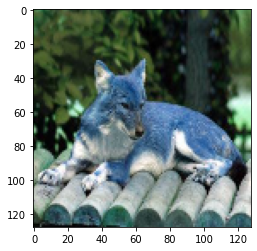

In [ ]:
plt.imshow(x_features[42])

In [ ]:
x_train,x_val,y_train,y_val=train_test_split(x_features,y_label,test_size=0.2,random_state=42)
print(x_train.shape)
print(x_val.shape)

(8177, 128, 128, 3)
(2045, 128, 128, 3)


In [ ]:
#Download the VGG weight file from here
#https://github.com/MinerKasch/applied_deep_learning/blob/master/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5

In [ ]:
# only create and load weights to the convolutional part of the VGG16 network
vgg_model = Sequential()
vgg_model.add(ZeroPadding2D((1,1),input_shape=(128,128, 3)))
vgg_model.add(Conv2D(64, (3,3), activation='relu', name='block1_conv1'))
vgg_model.add(ZeroPadding2D((1,1)))
vgg_model.add(Conv2D(64, (3,3), activation='relu', name='block1_conv2'))
vgg_model.add(MaxPooling2D((2,2), strides=(2,2)))

vgg_model.add(ZeroPadding2D((1,1)))
vgg_model.add(Conv2D(128, (3,3), activation='relu', name='block2_conv1'))
vgg_model.add(ZeroPadding2D((1,1)))
vgg_model.add(Conv2D(128, (3,3), activation='relu', name='block2_conv2'))
vgg_model.add(MaxPooling2D((2,2), strides=(2,2)))

vgg_model.add(ZeroPadding2D((1,1)))
vgg_model.add(Conv2D(256, (3,3), activation='relu', name='block3_conv1'))
vgg_model.add(ZeroPadding2D((1,1)))
vgg_model.add(Conv2D(256, (3,3), activation='relu', name='block3_conv2'))
vgg_model.add(ZeroPadding2D((1,1)))
vgg_model.add(Conv2D(256, (3,3), activation='relu', name='block3_conv3'))
vgg_model.add(MaxPooling2D((2,2), strides=(2,2)))

vgg_model.add(ZeroPadding2D((1,1)))
vgg_model.add(Conv2D(512, (3,3), activation='relu', name='block4_conv1'))
vgg_model.add(ZeroPadding2D((1,1)))
vgg_model.add(Conv2D(512, (3,3), activation='relu', name='block4_conv2'))
vgg_model.add(ZeroPadding2D((1,1)))
vgg_model.add(Conv2D(512, (3,3), activation='relu', name='block4_conv3'))
vgg_model.add(MaxPooling2D((2,2), strides=(2,2)))

vgg_model.add(ZeroPadding2D((1,1)))
vgg_model.add(Conv2D(512, (3,3), activation='relu', name='block5_conv1'))
vgg_model.add(ZeroPadding2D((1,1)))
vgg_model.add(Conv2D(512, (3,3), activation='relu', name='block5_conv2'))
vgg_model.add(ZeroPadding2D((1,1)))
vgg_model.add(Conv2D(512, (3,3), activation='relu', name='block5_conv3'))
vgg_model.add(MaxPooling2D((2,2), strides=(2,2)))

vgg_model.load_weights('/content/drive/My Drive/PGP-AIML/Capstone/Using CNN to classify Dog Breeds based on images/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', by_name=True)

vgg_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_39 (ZeroPaddi (None, 130, 130, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
zero_padding2d_40 (ZeroPaddi (None, 130, 130, 64)      0         
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 64, 64, 64)        0         
_________________________________________________________________
zero_padding2d_41 (ZeroPaddi (None, 66, 66, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)      

In [ ]:
# Add our own classifier layers on the bottom
vgg_model.add(Flatten(input_shape=(512,)))
vgg_model.add(Dense(256, activation='relu'))
vgg_model.add(Dense(120, activation='softmax'))

# optional set the convolutional layers so they won't be trained.
for layer in vgg_model.layers[:25]:
    layer.trainable = False

adam = Adam(lr=0.0001)
vgg_model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = vgg_model.fit(#x_train,np.asarray(y_train),
                        x_train,y_train,
                        validation_data=(x_val,y_val),
                        epochs=EPOCHS,
                        batch_size=BATCH,
                        #callbacks = [model_checkpoint,model_lr],
                        verbose=1)

Epoch 1/100
82/82 [==============================] - 26s 260ms/step - loss: 4.7870 - accuracy: 0.0094 - val_loss: 4.7858 - val_accuracy: 0.0093
Epoch 2/100
82/82 [==============================] - 18s 221ms/step - loss: 4.7849 - accuracy: 0.0110 - val_loss: 4.7793 - val_accuracy: 0.0068
Epoch 3/100
82/82 [==============================] - 17s 213ms/step - loss: 4.7728 - accuracy: 0.0110 - val_loss: 4.7630 - val_accuracy: 0.0171
Epoch 4/100
82/82 [==============================] - 17s 212ms/step - loss: 4.7529 - accuracy: 0.0147 - val_loss: 4.7302 - val_accuracy: 0.0200
Epoch 5/100
82/82 [==============================] - 18s 214ms/step - loss: 4.7101 - accuracy: 0.0230 - val_loss: 4.6764 - val_accuracy: 0.0210
Epoch 6/100
82/82 [==============================] - 18s 217ms/step - loss: 4.6509 - accuracy: 0.0260 - val_loss: 4.5949 - val_accuracy: 0.0249
Epoch 7/100
82/82 [==============================] - 18s 216ms/step - loss: 4.5479 - accuracy: 0.0317 - val_loss: 4.5183 - val_accuracy:

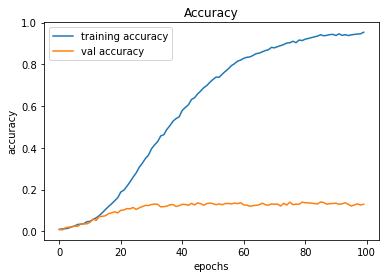

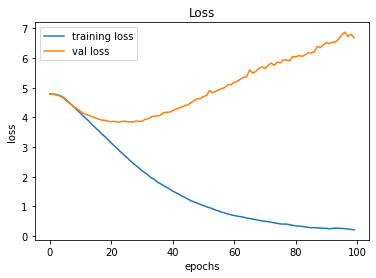

In [ ]:
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [ ]:
base_model = VGG16(weights='/content/drive/My Drive/PGP-AIML/Capstone/Using CNN to classify Dog Breeds based on images/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',
                   include_top=False, pooling='avg')

for layers in base_model.layers:
  layers.trainable=False

In [ ]:
#X_arr=[]
#X_arr=base_model.predict(preprocess_input(img_to_array(image.load_img('./train/'+labels['id'][0]))))

In [ ]:
x=base_model.output
#x=tf.keras.layers.Dense(1024,input_shape=(512,),activation='relu')(x)
x=tf.keras.layers.Dense(1024,activation='relu')(x)
x=tf.keras.layers.Dense(256,activation='relu')(x)
x=tf.keras.layers.Dense(120,activation='softmax')(x)
model3=tf.keras.Model(inputs=base_model.input,outputs=x)
model3.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model3.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [ ]:
history = model3.fit(#x_train,np.asarray(y_train),
                     x_train,y_train,
                     validation_data=(x_val,y_val),
                     epochs=EPOCHS,
                     batch_size=BATCH,
                     #callbacks = [model_checkpoint,model_lr],
                     verbose=1)

Epoch 1/100
82/82 [==============================] - 20s 192ms/step - loss: 4.7837 - accuracy: 0.0148 - val_loss: 4.6019 - val_accuracy: 0.0469
Epoch 2/100
82/82 [==============================] - 13s 161ms/step - loss: 4.4104 - accuracy: 0.0631 - val_loss: 4.0267 - val_accuracy: 0.0978
Epoch 3/100
82/82 [==============================] - 13s 163ms/step - loss: 3.8683 - accuracy: 0.1216 - val_loss: 3.7665 - val_accuracy: 0.1252
Epoch 4/100
82/82 [==============================] - 14s 166ms/step - loss: 3.4467 - accuracy: 0.1811 - val_loss: 3.5675 - val_accuracy: 0.1599
Epoch 5/100
82/82 [==============================] - 14s 168ms/step - loss: 3.2710 - accuracy: 0.2128 - val_loss: 3.4569 - val_accuracy: 0.1707
Epoch 6/100
82/82 [==============================] - 14s 169ms/step - loss: 3.0679 - accuracy: 0.2444 - val_loss: 3.3818 - val_accuracy: 0.1829
Epoch 7/100
82/82 [==============================] - 14s 169ms/step - loss: 2.9648 - accuracy: 0.2689 - val_loss: 3.3340 - val_accuracy:

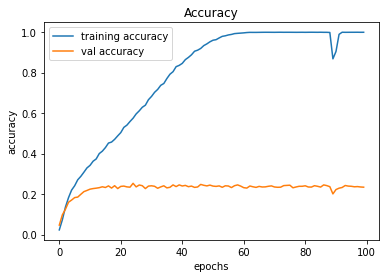

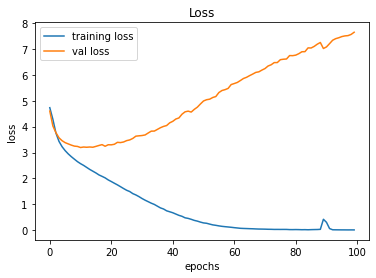

In [ ]:
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [ ]:
#model4=tf.keras.Model(inputs=base_model.input,outputs=x)
#model4.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
#history = model4.fit(training_data,epochs=EPOCHS,steps_per_epoch= 8177//BATCH,  #Number of training images//batch_size
                     #validation_data=testing_data, validation_steps = 2045//BATCH, #Number of test images//batch_size
                     #callbacks = [model_checkpoint,model_es,model_lr],verbose=1)

In [12]:
IMG_SIZE=224
channels=3
EPOCHS=20
BATCH=32
NUM_IMAGES = 10000

In [13]:
x_features=[]
label=[]

for f, img in tqdm(labels.values): #f for image id, img for dog breed
  #Using cv2.imread results in BGR images, instead of the standard RGB as below
  train_img = cv2.imread('./train/{}.jpg'.format(f),1) #0 for grayscale & 1 for color (o/p is bgr)
  train_img_resize = cv2.resize(train_img, (IMG_SIZE,IMG_SIZE))
  x_features.append(train_img_resize)
  label.append(img)

100%|██████████| 10222/10222 [00:30<00:00, 337.57it/s]


In [14]:
encoder = LabelEncoder()
label = encoder.fit_transform(label)
y_label=tf.keras.utils.to_categorical(label, num_classes=120, dtype='int')#, 120)

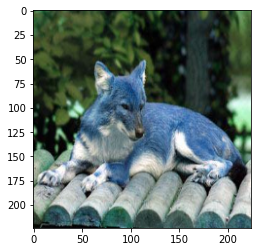

In [15]:
plt.imshow(x_features[42])

In [16]:
# Set number of images to use for experimenting
x_train,x_val,y_train,y_val=train_test_split(x_features[:NUM_IMAGES],
                                             y_label[:NUM_IMAGES],
                                             test_size=0.2,
                                             random_state=42)

In [17]:
x_train = np.array(x_train,np.float32)/255.0  #Division by 255. for normalisation
print(x_train.shape)

x_val = np.array(x_val,np.float32)/255.0  #Division by 255. for normalisation
print(x_val.shape)

#y_train = np.array(y_train)
#print(y_train.shape)

#y_val = np.array(y_val)
#print(y_val.shape)

(8000, 224, 224, 3)
(2000, 224, 224, 3)


In [18]:
# Setup input shape according to the pretrained-model input shape
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, colour channel ass

# Setup output shape of the model
OUTPUT_SHAPE = 120 # number of unique labels

# Setup model URL from TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"

In [19]:
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print("Building model with:", MODEL_URL)
  # Setup the model layers using sequential mode.
  model = tf.keras.Sequential([
                               hub.KerasLayer(MODEL_URL), # Layer 1 (the pre-trained model )
                               tf.keras.layers.Dense(units=512,activation="relu"), # Layer 2 (output layer)
                               tf.keras.layers.Dense(units=OUTPUT_SHAPE,activation="softmax") # Layer 2 (output layer)
                               ])
  # Compile the model
  model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=["accuracy"])
  # Build the model
  model.build(INPUT_SHAPE)
  return model

In [20]:
# Create a model and check its details
model4 = create_model()
model4.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              5432713   
_________________________________________________________________
dense (Dense)                (None, 512)               513024    
_________________________________________________________________
dense_1 (Dense)              (None, 120)               61560     
Total params: 6,007,297
Trainable params: 574,584
Non-trainable params: 5,432,713
_________________________________________________________________


In [21]:
tf.keras.backend.clear_session()

In [22]:
history = model4.fit(x_train,np.asarray(y_train),
                     validation_data=(x_val,np.asarray(y_val)),
                     epochs=EPOCHS,
                     batch_size=BATCH,
                     callbacks = [model_checkpoint,model_lr],
                     verbose=1)

Epoch 1/20
250/250 [==============================] - 27s 68ms/step - loss: 2.5321 - accuracy: 0.4088 - val_loss: 1.1651 - val_accuracy: 0.6525

Epoch 00001: val_accuracy improved from -inf to 0.65250, saving model to dogbreed_cnn.h5
Epoch 2/20
250/250 [==============================] - 16s 63ms/step - loss: 0.5286 - accuracy: 0.8376 - val_loss: 1.1475 - val_accuracy: 0.6625

Epoch 00002: val_accuracy improved from 0.65250 to 0.66250, saving model to dogbreed_cnn.h5
Epoch 3/20
250/250 [==============================] - 16s 63ms/step - loss: 0.2174 - accuracy: 0.9432 - val_loss: 1.2118 - val_accuracy: 0.6695

Epoch 00003: val_accuracy improved from 0.66250 to 0.66950, saving model to dogbreed_cnn.h5
Epoch 4/20
250/250 [==============================] - 16s 63ms/step - loss: 0.1187 - accuracy: 0.9690 - val_loss: 1.2332 - val_accuracy: 0.6760

Epoch 00004: val_accuracy improved from 0.66950 to 0.67600, saving model to dogbreed_cnn.h5
Epoch 5/20
250/250 [==============================] - 1

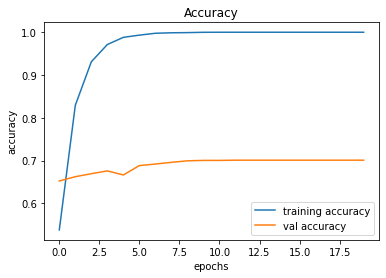

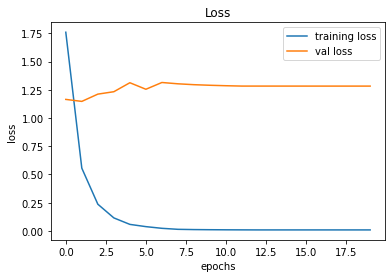

In [23]:
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [60]:
y_predict = model4.predict(x_val)
y_pred = []
y_roc_auc=[]
for val in y_predict:
    y_pred.append(np.argmax(val))
    y_roc_auc.append(val)
cm = metrics.confusion_matrix(np.argmax(y_val,axis=1),y_pred)
print(cm)

[[13  0  0 ...  0  1  0]
 [ 0 21  0 ...  0  0  0]
 [ 0  0 19 ...  0  0  0]
 ...
 [ 0  0  0 ...  7  0  0]
 [ 0  0  0 ...  0 12  0]
 [ 0  0  0 ...  0  0  9]]


In [25]:
cr=metrics.classification_report(np.argmax(y_val,axis=1),y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.93      0.81      0.87        16
           1       0.78      0.91      0.84        23
           2       0.95      0.90      0.93        21
           3       0.41      0.60      0.49        15
           4       0.38      0.50      0.43        10
           5       0.47      0.40      0.43        20
           6       0.73      0.61      0.67        18
           7       0.63      0.80      0.71        15
           8       0.73      0.85      0.79        13
           9       0.61      0.64      0.62        22
          10       0.95      0.91      0.93        22
          11       0.72      0.91      0.81        23
          12       0.60      0.50      0.55        12
          13       0.77      0.91      0.83        11
          14       0.86      0.63      0.73        19
          15       0.75      0.83      0.79        18
          16       0.55      0.43      0.48        14
          17       0.88    

In [26]:
print ('ROC-AUC Score: ', metrics.roc_auc_score(y_val,y_roc_auc,average='weighted',multi_class='ovo'))

ROC-AUC Score:  0.9936935892189772


Actual Dog Breed:  ['kelpie']
Predicted Dog Breed:  ['kelpie']


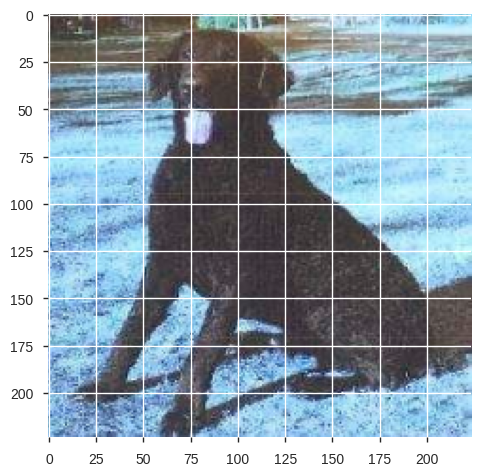

In [63]:
plt.imshow(x_val[20])
print('Actual Dog Breed: ',encoder.inverse_transform([np.argmax(y_val[42])]))
print('Predicted Dog Breed: ',encoder.inverse_transform([y_pred[42]]))

In [27]:
#from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(#preprocessing_function=preprocess_input,
                                                                width_shift_range=0.2,
                                                                height_shift_range=0.2,
                                                                #rescale=1./255,
                                                                rotation_range=30,
                                                                shear_range=0.2,
                                                                zoom_range=0.2,
                                                                horizontal_flip=True,
                                                                vertical_flip=True,
                                                                fill_mode='nearest')
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

In [28]:
training_data = train_datagen.flow(x_train,y=np.asarray(y_train),batch_size=BATCH)
testing_data = test_datagen.flow(x_val,y=np.asarray(y_val),batch_size=BATCH)

In [29]:
tf.keras.backend.clear_session()

In [30]:
# Create a model and check its details
model5 = create_model()
model5.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              5432713   
_________________________________________________________________
dense (Dense)                (None, 512)               513024    
_________________________________________________________________
dense_1 (Dense)              (None, 120)               61560     
Total params: 6,007,297
Trainable params: 574,584
Non-trainable params: 5,432,713
_________________________________________________________________


In [31]:
history = model5.fit(training_data,
                     epochs=EPOCHS,
                     steps_per_epoch= 4000//BATCH,  #Number of training images//batch_size
                     validation_data=testing_data,
                     validation_steps = 1000//BATCH, #Number of test images//batch_size,
                     callbacks = [model_checkpoint,model_lr],
                     verbose=1)

Epoch 1/20
125/125 [==============================] - 45s 333ms/step - loss: 4.3004 - accuracy: 0.1249 - val_loss: 1.7812 - val_accuracy: 0.4909

Epoch 00001: val_accuracy did not improve from 0.70100
Epoch 2/20
125/125 [==============================] - 41s 331ms/step - loss: 2.3823 - accuracy: 0.3839 - val_loss: 1.3722 - val_accuracy: 0.5776

Epoch 00002: val_accuracy did not improve from 0.70100
Epoch 3/20
125/125 [==============================] - 41s 328ms/step - loss: 2.0374 - accuracy: 0.4592 - val_loss: 1.3188 - val_accuracy: 0.5988

Epoch 00003: val_accuracy did not improve from 0.70100
Epoch 4/20
125/125 [==============================] - 41s 329ms/step - loss: 1.8760 - accuracy: 0.5004 - val_loss: 1.3806 - val_accuracy: 0.5867

Epoch 00004: val_accuracy did not improve from 0.70100
Epoch 5/20
125/125 [==============================] - 41s 329ms/step - loss: 1.7298 - accuracy: 0.5275 - val_loss: 1.3449 - val_accuracy: 0.6109

Epoch 00005: val_accuracy did not improve from 0.7

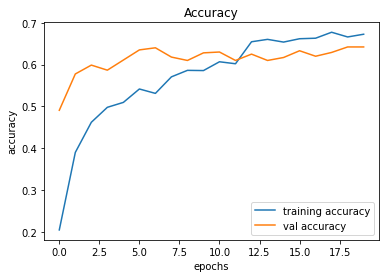

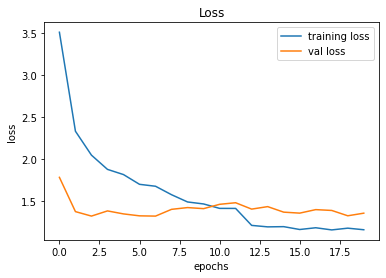

In [32]:
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [33]:
y_predict = model5.predict(x_val)
y_pred = []
y_roc_auc=[]
for val in y_predict:
    y_pred.append(np.argmax(val))
    y_roc_auc.append(val)
cm = metrics.confusion_matrix(np.argmax(y_val,axis=1),y_pred)
print(cm)

[[12  0  0 ...  0  0  0]
 [ 0 18  0 ...  0  0  0]
 [ 0  0 18 ...  0  0  0]
 ...
 [ 0  0  0 ...  6  0  0]
 [ 0  0  0 ...  0 11  0]
 [ 0  0  0 ...  0  0  9]]


In [34]:
cr=metrics.classification_report(np.argmax(y_val,axis=1),y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.80      0.75      0.77        16
           1       0.75      0.78      0.77        23
           2       0.90      0.86      0.88        21
           3       0.80      0.53      0.64        15
           4       0.28      0.50      0.36        10
           5       0.57      0.40      0.47        20
           6       0.55      0.61      0.58        18
           7       0.53      0.53      0.53        15
           8       0.82      0.69      0.75        13
           9       0.55      0.73      0.63        22
          10       1.00      0.86      0.93        22
          11       0.73      0.83      0.78        23
          12       0.80      0.33      0.47        12
          13       0.91      0.91      0.91        11
          14       0.63      0.63      0.63        19
          15       0.76      0.72      0.74        18
          16       0.62      0.57      0.59        14
          17       0.74    

In [35]:
print ('ROC-AUC Score: ', metrics.roc_auc_score(y_val,y_roc_auc,average='weighted',multi_class='ovo'))

ROC-AUC Score:  0.9910816864604671


Actual Dog Breed: ['labrador_retriever']
Predicted Dog Breed:  ['labrador_retriever']


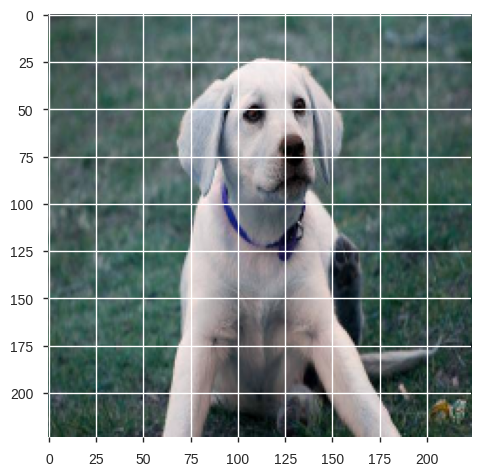

In [59]:
plt.imshow(x_val[10])
print('Actual Dog Breed:',encoder.inverse_transform([np.argmax(y_val[10])]))
print('Predicted Dog Breed: ',encoder.inverse_transform([y_pred[10]]))